# Convert tile prediction results to whole slide image:

In [54]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter('ignore')

def generate_tile_annotation_summaries(df, pil_img, tile_size, mode):
    draw_img = ImageDraw.Draw(pil_img)
    df = df.loc[:,['row', 'col', 'pattern_label', 'pattern_prob', 'tils_label', 'tils_prob']]
    for _, data in df.iterrows():
        r, c, pattern_label, pattern_prob, tils_label, tils_prob = data.to_list()
        if mode == 'pattern':
            color = tile_annotation_border_color(pattern_label, pattern_prob)
            tile_border(draw_img, (r-1)*tile_size, r*tile_size, (c-1)*tile_size, c*tile_size, color)
        if mode == 'tils':
            color = tile_annotation_border_color(tils_label, tils_prob) 
            tile_border(draw_img, (r-1)*tile_size, r*tile_size, (c-1)*tile_size, c*tile_size, color)
    return pil_img


def tile_border(draw, r_s, r_e, c_s, c_e, color):
    draw.rectangle([(c_s, r_s), (c_e - 1, r_e - 1)], fill=color)

    
def tile_annotation_border_color(tissue_label, prob):
    if tissue_label == 'MT':
        border_color = (int(255*prob),0,0) # Red
    elif tissue_label == 'PG':
        border_color = (0,int(255*prob),0) # Green
    elif tissue_label == 'SP':
        border_color = (0,0,int(255*prob)) # Blue
    elif tissue_label == 'UD':
        border_color = (int(255*prob),int(255*prob),int(255*prob)) # White
    elif tissue_label == 1.0:
        border_color = (int(255*prob), 0, int(255*prob)) # Purple
    else:
        border_color = (0,0,0)
    return border_color

def get_annotation_summary_image_filename(case_id, mode):
    ext = 'jpg'
    img_filename = case_id + '_' + mode + '.' + ext
    return img_filename

def get_annotation_summary_image_path(case_id, working_dir, mode):
    os.makedirs(working_dir, exist_ok=True)
    img_path = os.path.join(working_dir, get_annotation_summary_image_filename(case_id, mode))
    return img_path

def create_summary_pil_img(np_img, title_area_height, row_tile_size, col_tile_size, num_row_tiles, num_col_tiles):
    r = row_tile_size * num_row_tiles + title_area_height
    c = col_tile_size * num_col_tiles
    summary_img = np.zeros([r, c, np_img.shape[2]], dtype=np.uint8)
    # add gray edges so that tile text does not get cut off
    summary_img.fill(0)
    # color title area white
    summary_img[0:title_area_height, 0:summary_img.shape[1]].fill(255)
    summary_img[title_area_height:np_img.shape[0] + title_area_height, 0:np_img.shape[1]] = np_img
    summary = np_to_pil(summary_img)
    return summary

def np_to_pil(np_img):
    if np_img.dtype == "bool":
        np_img = np_img.astype("uint8") * 255
    elif np_img.dtype == "float64":
        np_img = (np_img * 255).astype("uint8")
    return Image.fromarray(np_img)

def percent(value, num_tumor):
    return round(value / num_tumor, 3)

In [55]:
BASE_DIR = './predictions/'
project_lists = ['TCGA', 'JGOG', 'Kindai']
color_dicts = {'MT': 'Red', 'PG': 'Green', 'SP': 'Blue', 'IR':'Purple', 'UD': 'White'}
annotation_tile_size = 10
group_cut_off = 5

for idx, project in enumerate(project_lists):
    df_he_annotation = pd.read_csv(os.path.dirname(os.path.dirname(BASE_DIR)) + '/HE_annotation_%s.csv'%project).iloc[:,:7]
    num_match_lists = list()
    for _, data in df_he_annotation.iloc[:,2:7].iterrows():
        annotation_lists = data.values.tolist()
        num_match = sum(x==annotation_lists[4] for x in annotation_lists[:4])
        num_match_lists.append(num_match)
    df_he_annotation['num_match'] = num_match_lists
    working_dir = BASE_DIR+'predictions_%s/'%project
    prediction_files = sorted(glob.glob(working_dir + 'dataframe/%s_*.csv'%project))
    column_names = ['annotation_id' , 'p_MT', 'p_PG', 'p_SP', 'p_TIL', 'p_UD', 
                                    'num_tiles', 'num_tumor', 'num_MT', 'num_PG', 'num_SP', 'num_UD', 'num_TIL', 
                                   ]
    df_predictions = pd.DataFrame(columns = column_names)
    with tqdm(total=len(prediction_files), desc='Processing %s'%project) as pbar:
        for fp in prediction_files:
            df = pd.read_csv(fp)
            case_id = df['ID'].values.tolist()[0]
            df = df[df['tile_filename'].notnull()]
            num_tiles = len(df)
            if num_tiles ==0:
                num_tumor, tiles_MT, tiles_PG, tiles_SP, tiles_UD, tiles_TIL = 0,0,0,0,0,0
            else:
                tiles_ST = len(df[df['pattern_label']=='ST'])
                num_tumor = num_tiles - tiles_ST
                tiles_MT = len(df[df['pattern_label']=='MT'])
                tiles_PG = len(df[df['pattern_label']=='PG'])
                tiles_SP = len(df[df['pattern_label']=='SP'])
                tiles_UD = len(df[df['pattern_label']=='UD'])
                tiles_TIL = len(df[df['tils_label']==1.0])
                if num_tumor==0:
                    p_MT, p_PG, p_SP, p_UD, p_TIL = 0,0,0,0,0
                else:
                    p_MT, p_PG, p_SP, p_UD, p_TIL = percent(tiles_MT, num_tumor), percent(tiles_PG,num_tumor), percent(tiles_SP,num_tumor), percent(tiles_UD,num_tumor), percent(tiles_TIL,num_tumor)
                    np_img_path = glob.glob(working_dir + 'training_png/%s-*.png'%case_id)[0]
                    np_orig = np.array(Image.open(np_img_path))
                    row_tile_size, col_tile_size, num_row_tiles, num_col_tiles = df['scaled_tile_w'].values.tolist()[0], df['scaled_tile_h'].values.tolist()[0], df['num_row_tiles'].values.tolist()[0], df['num_col_tiles'].values.tolist()[0]
                    summary_orig = create_summary_pil_img(np_orig, 0, row_tile_size, col_tile_size, num_row_tiles, num_col_tiles)
                    annotation_img = np.zeros([num_row_tiles*annotation_tile_size, num_col_tiles*annotation_tile_size, 3], dtype=np.uint8)
                    annotation_pattern_img = generate_tile_annotation_summaries(df, np_to_pil(annotation_img), annotation_tile_size, mode='pattern')
                    annotation_pattern_img = Image.blend(summary_orig, annotation_pattern_img.resize(summary_orig.size), 0.3)
                    annotation_tils_img = generate_tile_annotation_summaries(df, np_to_pil(annotation_img), annotation_tile_size, mode='tils')
                    annotation_tils_img = Image.blend(summary_orig, annotation_tils_img.resize(summary_orig.size), 0.3)
                    annotation_pattern_img.save(get_annotation_summary_image_path(case_id, working_dir +'annotation_pattern', mode='pattern'))
                    annotation_tils_img.save(get_annotation_summary_image_path(case_id, working_dir+'annotation_tils', mode='tils'))

            _df_predictions = pd.DataFrame([(case_id, p_MT, p_PG, p_SP, p_TIL, p_UD, 
                                              num_tiles, num_tumor, tiles_MT, tiles_PG, tiles_SP, tiles_UD, tiles_TIL,
                                              )], 
                                              columns = column_names)
            df_predictions = df_predictions.append(_df_predictions, ignore_index=True)
            pbar.update(1)
            
        df_he_annotation = pd.merge(df_he_annotation, df_predictions, on='annotation_id')
        df_he_annotation.to_csv(working_dir + 'HE_annotation_%s.csv'%project, index=False)

Processing TCGA:   0%|          | 0/102 [00:00<?, ?it/s]

Processing JGOG:   0%|          | 0/80 [00:00<?, ?it/s]

Processing Kindai:   0%|          | 0/59 [00:00<?, ?it/s]

# Analysing parameters (MT and IR thresholds) from TCGA cases

## Total accuracy to predict classification of four subtypes

In [49]:
import pandas as pd
import numpy as np
import collections
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def analysis_total(df, MT_threshold, IR_threshold):
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP'  
    accuracy = len(df[df['prediction']==df['type']])/len(df['type'])
    return accuracy

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_total(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, TCGA accuracy: %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.15, tTIL threshold: 0.19, TCGA accuracy: 0.866


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

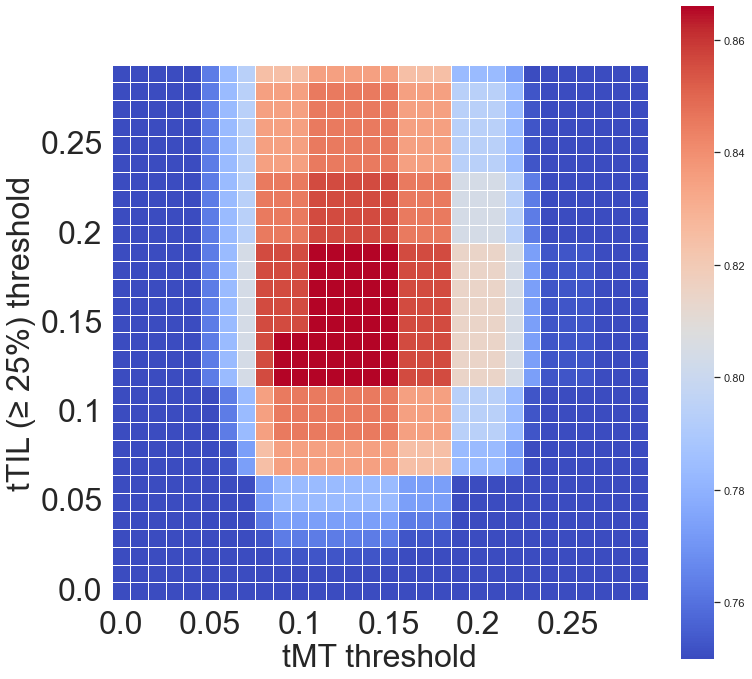

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12)) 

ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.75, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

[Text(0, 0.5, '0.2'),
 Text(0, 1.5, '0.19'),
 Text(0, 2.5, '0.18'),
 Text(0, 3.5, '0.17'),
 Text(0, 4.5, '0.16'),
 Text(0, 5.5, '0.15'),
 Text(0, 6.5, '0.14'),
 Text(0, 7.5, '0.13'),
 Text(0, 8.5, '0.12'),
 Text(0, 9.5, '0.11')]

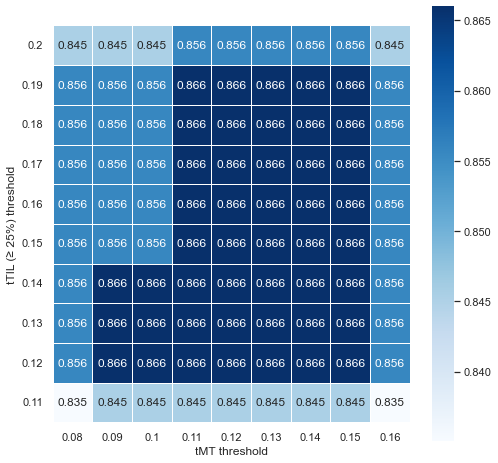

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.heatmap(df.iloc[11:21, 8:17].sort_index(ascending=False), cmap='Blues', square=True, linewidth=.5, annot=True, fmt='.3f')
ax.set(xlabel='tMT threshold', ylabel='tTIL (≥ 25%) threshold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

## Macro avarages for prediction accuracies of classification in four subtypes

In [52]:
import pandas as pd
import numpy as np
import collections
import warnings
from sklearn import metrics
warnings.simplefilter('ignore')

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def analysis_macro_average(df, MT_threshold, IR_threshold):
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP' 
    accuracy_MT, auc_MT = evaluate_accuracy_subtype('MT', df)
    accuracy_IR, auc_IR = evaluate_accuracy_subtype('IR', df)
    accuracy_PG, auc_PG = evaluate_accuracy_subtype('PG', df)
    accuracy_SP, auc_SP = evaluate_accuracy_subtype('SP', df)
    return np.average(np.array([accuracy_MT, accuracy_IR, accuracy_PG, accuracy_SP]))

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_macro_average(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, Micro average for accuracy: %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.15, tTIL threshold: 0.14, Micro average for accuracy: 0.933


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

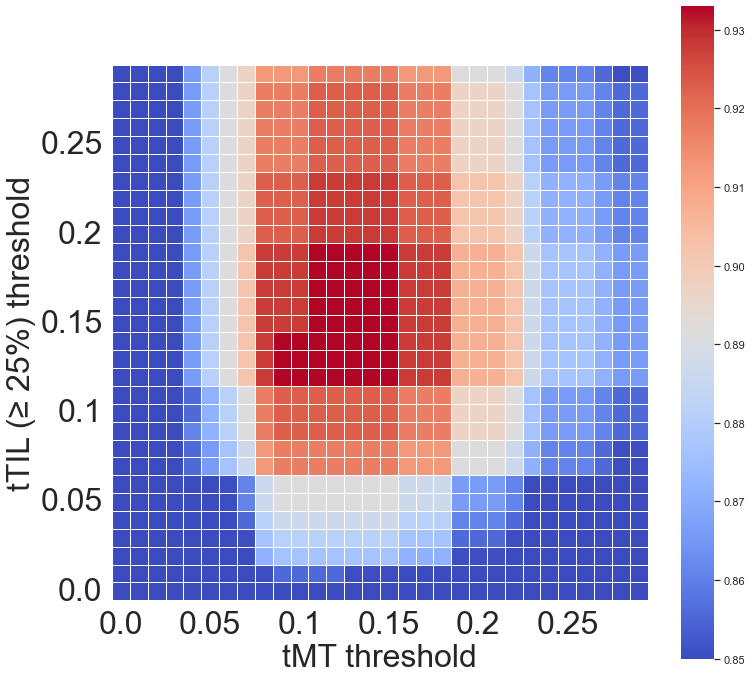

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12)) 

ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.85, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

[Text(0, 0.5, '0.2'),
 Text(0, 1.5, '0.19'),
 Text(0, 2.5, '0.18'),
 Text(0, 3.5, '0.17'),
 Text(0, 4.5, '0.16'),
 Text(0, 5.5, '0.15'),
 Text(0, 6.5, '0.14'),
 Text(0, 7.5, '0.13'),
 Text(0, 8.5, '0.12'),
 Text(0, 9.5, '0.11')]

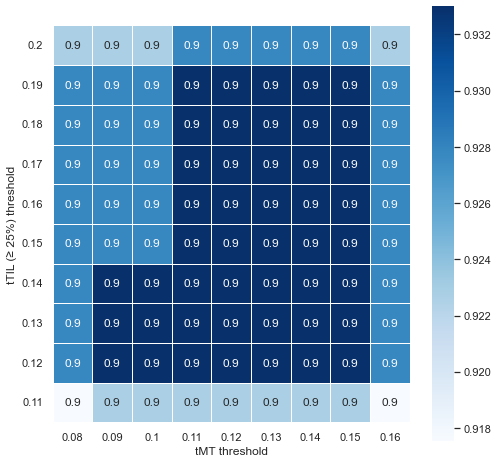

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.heatmap(df.iloc[11:21, 8:17].sort_index(ascending=False), cmap='Blues', square=True, linewidth=.5, annot=True, fmt='.1f')
ax.set(xlabel='tMT threshold', ylabel='tTIL (≥ 25%) threshold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

## Macro avarages for roc auc of classification in four subtypes

In [57]:
import pandas as pd
import numpy as np
import collections
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def analysis_macro_average(df, MT_threshold, IR_threshold):
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP' 
    accuracy_MT, auc_MT = evaluate_accuracy_subtype('MT', df)
    accuracy_IR, auc_IR = evaluate_accuracy_subtype('IR', df)
    accuracy_PG, auc_PG = evaluate_accuracy_subtype('PG', df)
    accuracy_SP, auc_SP = evaluate_accuracy_subtype('SP', df)
    return np.average(np.array([auc_MT, auc_IR, auc_PG, auc_SP]))

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_macro_average(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, Micro average for auc: %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.15, tTIL threshold: 0.14, Micro average for auc: 0.904


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

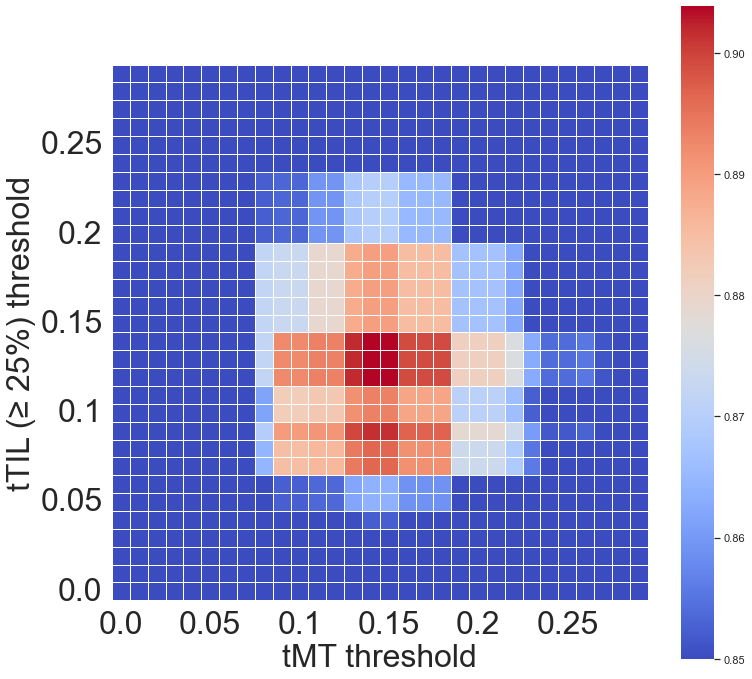

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.85, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

[Text(0, 0.5, '0.2'),
 Text(0, 1.5, '0.19'),
 Text(0, 2.5, '0.18'),
 Text(0, 3.5, '0.17'),
 Text(0, 4.5, '0.16'),
 Text(0, 5.5, '0.15'),
 Text(0, 6.5, '0.14'),
 Text(0, 7.5, '0.13'),
 Text(0, 8.5, '0.12'),
 Text(0, 9.5, '0.11')]

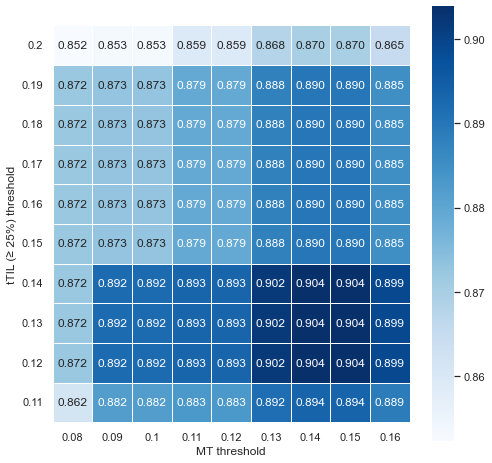

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.heatmap(df.iloc[11:21, 8:17].sort_index(ascending=False), cmap='Blues', square=True, linewidth=.5, annot=True, fmt='.3f')
ax.set(xlabel='MT threshold', ylabel='tTIL (≥ 25%) threshold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Roc auc of classification of each subtype

## MT subtype

In [60]:
import pandas as pd
import numpy as np
import collections
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def analysis_macro_average(df, MT_threshold, IR_threshold):
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP' 
    accuracy_MT, auc_MT = evaluate_accuracy_subtype('MT', df)
#     accuracy_IR, auc_IR = evaluate_accuracy_subtype('IR', df)
#     accuracy_PG, auc_PG = evaluate_accuracy_subtype('PG', df)
#     accuracy_SP, auc_SP = evaluate_accuracy_subtype('SP', df)
    return auc_MT

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_macro_average(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, AUC: %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.12, tTIL threshold: 0.29, AUC: 0.930


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

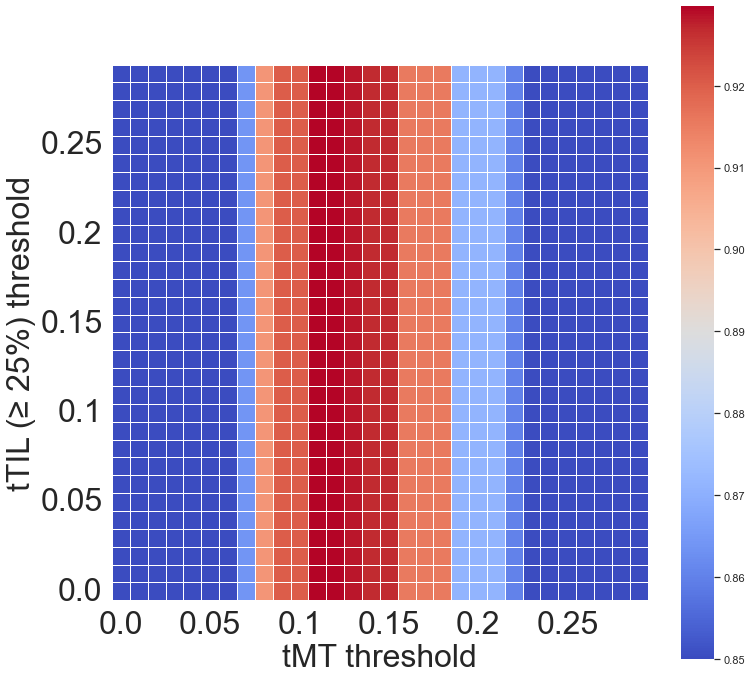

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.85, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

## IR subtype

In [64]:
import pandas as pd
import numpy as np
import collections
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def analysis_macro_average(df, MT_threshold, IR_threshold):
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP' 
    #accuracy_MT, auc_MT = evaluate_accuracy_subtype('MT', df)
    accuracy_IR, auc_IR = evaluate_accuracy_subtype('IR', df)
#     accuracy_PG, auc_PG = evaluate_accuracy_subtype('PG', df)
#     accuracy_SP, auc_SP = evaluate_accuracy_subtype('SP', df)
    return auc_IR

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_macro_average(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, AUC : %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.10, tTIL threshold: 0.09, AUC : 0.912


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

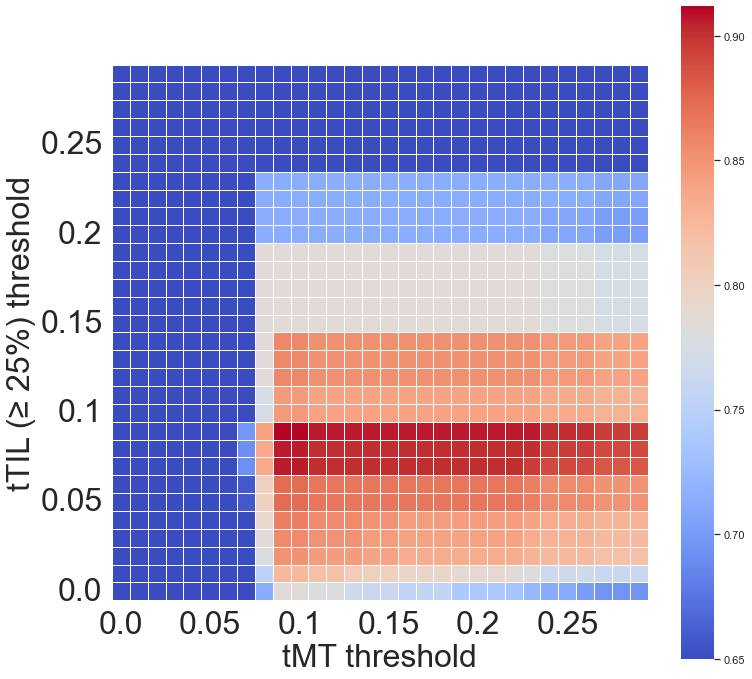

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.65, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

## PG subtype

In [66]:
import pandas as pd
import numpy as np
import collections
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def analysis_macro_average(df, MT_threshold, IR_threshold):
    df = df[df['num_tumor']>=20]
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP' 
    #accuracy_MT, auc_MT = evaluate_accuracy_subtype('MT', df)
    #accuracy_IR, auc_IR = evaluate_accuracy_subtype('IR', df)
    accuracy_PG, auc_PG = evaluate_accuracy_subtype('PG', df)
    #accuracy_SP, auc_SP = evaluate_accuracy_subtype('SP', df)
    return auc_PG

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_macro_average(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, AUC: %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.15, tTIL threshold: 0.19, AUC: 0.893


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

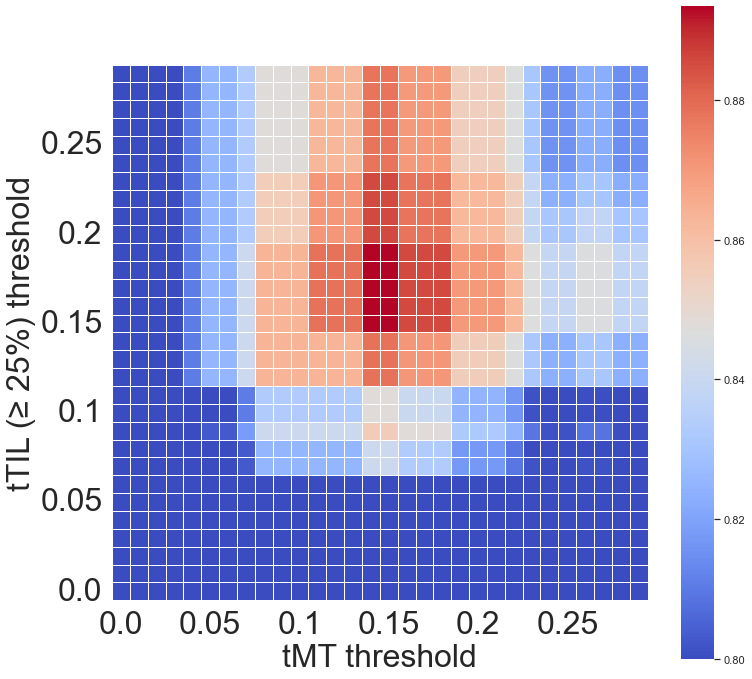

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.80, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

## SP subtype

In [68]:
import pandas as pd
import numpy as np
import collections
import warnings
warnings.simplefilter('ignore')
from sklearn import metrics

df_TCGA = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv')

def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def analysis_macro_average(df, MT_threshold, IR_threshold):
    df = df[(df['type']!='UD')]
    countMT, countPG, countSP, countIR = len(df[df['type']=='MT']), len(df[df['type']=='PG']), len(df[df['type']=='SP']), len(df[df['type']=='IR'])
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP' 
    #accuracy_MT, auc_MT = evaluate_accuracy_subtype('MT', df)
    #accuracy_IR, auc_IR = evaluate_accuracy_subtype('IR', df)
    #accuracy_PG, auc_PG = evaluate_accuracy_subtype('PG', df)
    accuracy_SP, auc_SP = evaluate_accuracy_subtype('SP', df)
    return auc_SP

df = pd.DataFrame()
MT_threshold, IR_threshold, score = 0, 0, 0
for x in np.arange(0, 0.3, 0.01):
    for y in np.arange(0, 0.3, 0.01):
        prediction = analysis_macro_average(df_TCGA, x, y)
        df.at[y,x] = prediction
        if prediction >= score:
            score = prediction
            MT_threshold = x
            IR_threshold = y
print('tMT threshold: %.02f, tTIL threshold: %.02f, AUC: %.03f' % (MT_threshold, IR_threshold, score))

tMT threshold: 0.13, tTIL threshold: 0.14, AUC: 0.965


[Text(0, 0.5, ''),
 Text(0, 1.5, ''),
 Text(0, 2.5, ''),
 Text(0, 3.5, ''),
 Text(0, 4.5, '0.25'),
 Text(0, 5.5, ''),
 Text(0, 6.5, ''),
 Text(0, 7.5, ''),
 Text(0, 8.5, ''),
 Text(0, 9.5, '0.2'),
 Text(0, 10.5, ''),
 Text(0, 11.5, ''),
 Text(0, 12.5, ''),
 Text(0, 13.5, ''),
 Text(0, 14.5, '0.15'),
 Text(0, 15.5, ''),
 Text(0, 16.5, ''),
 Text(0, 17.5, ''),
 Text(0, 18.5, ''),
 Text(0, 19.5, '0.1'),
 Text(0, 20.5, ''),
 Text(0, 21.5, ''),
 Text(0, 22.5, ''),
 Text(0, 23.5, ''),
 Text(0, 24.5, '0.05'),
 Text(0, 25.5, ''),
 Text(0, 26.5, ''),
 Text(0, 27.5, ''),
 Text(0, 28.5, ''),
 Text(0, 29.5, '0.0')]

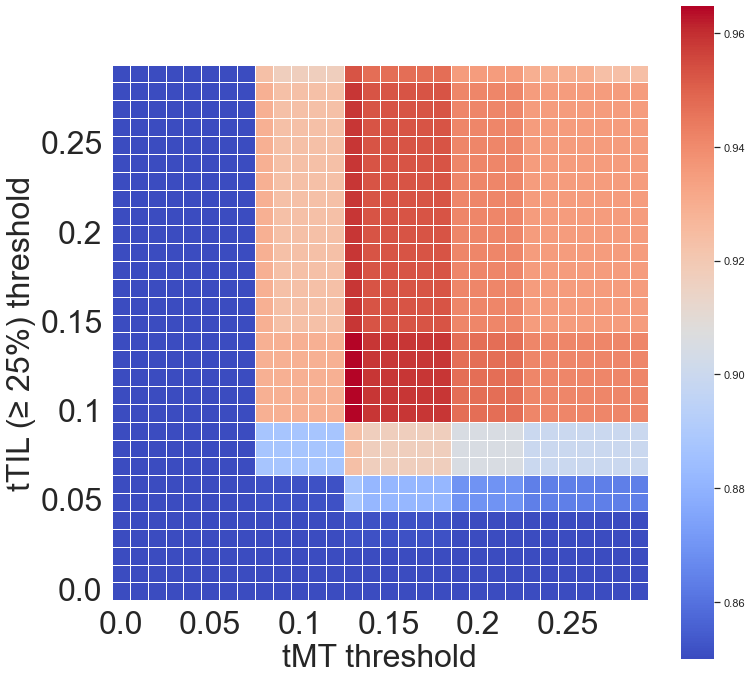

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(df.sort_index(ascending=False), vmin= 0.85, vmax= np.max(df.values), cmap='coolwarm', square=True, linewidth=.5, annot=False, cbar=True)
ax.set_xlabel('tMT threshold', fontsize=32)
ax.set_ylabel('tTIL (≥ 25%) threshold', fontsize=32)
ax.set_xticklabels([i*0.01 if i%5==0 else "" for i in range(30)], rotation=0, fontsize=32)
ax.set_yticklabels([(29-i)*0.01 if (29-i)%5==0 else "" for i in range(30)], rotation=0, fontsize=32)

## Predictions : 4 subtypes 

In [71]:
import pandas as pd
import numpy as np
import collections
import warnings
from sklearn import metrics

MT_threshold = 0.15
IR_threshold = 0.14

df_TCGA_path = '/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_annotation_TCGA.csv'
df_JGOG_path = '/Users/aueda/Python/Kindai/5class/predictions_JGOG/HE_annotation_JGOG.csv'
df_Kindai_path ='/Users/aueda/Python/Kindai/5class/predictions_Kindai/HE_annotation_Kindai.csv'


def evaluate_accuracy_subtype(subtype, df):
    _df = df 
    _df.loc[(_df['type']==subtype), '_annotation_%s'%subtype]=1
    _df.loc[(_df['_annotation_%s'%subtype].isnull()), '_annotation_%s'%subtype]=0
    _df.loc[(_df['prediction']==subtype), '_prediction_%s'%subtype]=1
    _df.loc[(_df['_prediction_%s'%subtype].isnull()), '_prediction_%s'%subtype]=0
    # Accuracy of prediction
    accuracy = len(_df[_df['_prediction_%s'%subtype]==_df['_annotation_%s'%subtype]])/len(_df['_annotation_%s'%subtype])
    # Calculate Area under the curve value
    fpr, tpr, thresholds = metrics.roc_curve(_df['_annotation_%s'%subtype].values, _df['_prediction_%s'%subtype].values)
    auc = metrics.auc(fpr, tpr)
    TP = len(_df[(_df['_annotation_%s'%subtype]==1)&(_df['_prediction_%s'%subtype]==1)])
    FN = len(_df[(_df['_annotation_%s'%subtype]==1)&(_df['_prediction_%s'%subtype]==0)])
    FP = len(_df[(_df['_annotation_%s'%subtype]==0)&(_df['_prediction_%s'%subtype]==1)])
    TN = len(_df[(_df['_annotation_%s'%subtype]==0)&(_df['_prediction_%s'%subtype]==0)])
    df_summary = pd.DataFrame({'%s_Accuracy'%subtype:[accuracy], 
                                                         '%s_AUC'%subtype:[auc], 
                                                         '%s_TP'%subtype: TP, 
                                                         '%s_FN'%subtype: FN,
                                                         '%s_FP'%subtype: FP,
                                                         '%s_TN'%subtype: TN,
                                                         '%s_Sensitivity'%subtype: TP/(TP+FN),
                                                         '%s_Specificity'%subtype: TN/(FP+TN)
                                                          })    
    return accuracy, auc, df_summary

def evaluate_dataset(df_path, MT_threshold, IR_threshold):
    df = pd.read_csv(df_path).iloc[:,:20]
    df.loc[(df['p_MT']>MT_threshold), 'prediction'] = 'MT'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']>IR_threshold), 'prediction'] = 'IR'
    df.loc[(df['p_MT']<=MT_threshold)&(df['p_TIL']<=IR_threshold)&(df['p_PG']>df['p_SP']), 'prediction'] = 'PG'
    df.loc[(df['prediction'].isnull()), 'prediction']='SP'
    df.loc[(df['type']=='MT'), 'annotation_MT']='MT'
    df.loc[(df['annotation_MT'].isnull()), 'annotation_MT']='nonMT'
    df.loc[(df['prediction']=='MT'), 'prediction_MT']='MT'
    df.loc[(df['prediction_MT'].isnull()), 'prediction_MT']='nonMT' 
    df_export = pd.concat([df.iloc[:,:7], df.iloc[:,20:], df.iloc[:,7:20]],axis=1)
    export_path = df_path.split('HE')[0] + 'HE_prediction_'+ df_path.split('_')[-1]
    df_export.to_csv(export_path, index=False)

    df = df[(df['type']!='UD')]
    num_cases = len(df['type'].values)
    correct_cases = sum(df['prediction'].values==df['type'].values)
    accuracy = correct_cases/num_cases
    accuracy_MT, auc_MT, df_summary_MT = evaluate_accuracy_subtype('MT', df)
    accuracy_IR, auc_IR, df_summary_IR = evaluate_accuracy_subtype('IR', df)
    accuracy_PG, auc_PG, df_summary_PG = evaluate_accuracy_subtype('PG', df)
    accuracy_SP, auc_SP, df_summary_SP = evaluate_accuracy_subtype('SP', df)
    accuracy_lists = [accuracy, accuracy_MT, accuracy_IR, accuracy_PG, accuracy_SP]
    auc_lists = [auc_MT, auc_IR, auc_PG, auc_SP]
    df_summary = pd.concat([df_summary_MT, df_summary_IR, df_summary_PG, df_summary_SP], axis=1)
    return num_cases, correct_cases, accuracy_lists, auc_lists, df_summary

TCGA_num_cases, TCGA_correct_cases, TCGA_accuracy_lists, TCGA_auc_lists, TCGA_df_summary = evaluate_dataset(df_TCGA_path, MT_threshold, IR_threshold)
JGOG_num_cases, JGOG_correct_cases, JGOG_accuracy_lists, JGOG_auc_lists, JGOG_df_summary = evaluate_dataset(df_JGOG_path, MT_threshold, IR_threshold)
Kindai_num_cases, Kindai_correct_cases, Kindai_accuracy_lists, Kindai_auc_lists, Kindai_df_summary = evaluate_dataset(df_Kindai_path, MT_threshold, IR_threshold)

print('Prediction results')
print('TCGA: %.3f (%d/%d)'%(TCGA_accuracy_lists[0], TCGA_correct_cases, TCGA_num_cases))
print('MT: Accuracy %.3f (AUC %.3f), IR : Accuracy %.3f (AUC %.3f), PG: Accuracy %.3f (AUC %.3f), SP: Accuracy %.3f (AUC %.3f)'%(
    TCGA_accuracy_lists[1], TCGA_auc_lists[0],
    TCGA_accuracy_lists[2], TCGA_auc_lists[1],
    TCGA_accuracy_lists[3], TCGA_auc_lists[2],
    TCGA_accuracy_lists[4], TCGA_auc_lists[3]))
print('JGOG: %.3f (%d/%d)'%(JGOG_accuracy_lists[0], JGOG_correct_cases, JGOG_num_cases))
print('MT: Accuracy %.3f (AUC %.3f), IR : Accuracy %.3f (AUC %.3f), PG: Accuracy %.3f (AUC %.3f), SP: Accuracy %.3f (AUC %.3f)'%(
    JGOG_accuracy_lists[1], JGOG_auc_lists[0],
    JGOG_accuracy_lists[2], JGOG_auc_lists[1],
    JGOG_accuracy_lists[3], JGOG_auc_lists[2],
    JGOG_accuracy_lists[4], JGOG_auc_lists[3]))
print('Kindai: %.3f (%d/%d)'%(Kindai_accuracy_lists[0], Kindai_correct_cases, Kindai_num_cases))
print('MT: Accuracy %.3f (AUC %.3f), IR : Accuracy %.3f (AUC %.3f), PG: Accuracy %.3f (AUC %.3f), SP: Accuracy %.3f (AUC %.3f)'%(
    Kindai_accuracy_lists[1], Kindai_auc_lists[0],
    Kindai_accuracy_lists[2], Kindai_auc_lists[1],
    Kindai_accuracy_lists[3], Kindai_auc_lists[2],
    Kindai_accuracy_lists[4], Kindai_auc_lists[3]))

pd.set_option('display.max_columns', None)

df_summary = pd.concat([TCGA_df_summary, JGOG_df_summary, Kindai_df_summary], axis=0)
df_summary['Total_cases'] = [TCGA_num_cases, JGOG_num_cases, Kindai_num_cases]
df_summary.index= ['TCGA', 'JGOG', 'Kindai']
df_summary

Prediction results
TCGA: 0.866 (84/97)
MT: Accuracy 0.928 (AUC 0.927), IR : Accuracy 0.969 (AUC 0.852), PG: Accuracy 0.907 (AUC 0.878), SP: Accuracy 0.928 (AUC 0.959)
JGOG: 0.819 (59/72)
MT: Accuracy 0.847 (AUC 0.863), IR : Accuracy 0.944 (AUC 0.667), PG: Accuracy 0.889 (AUC 0.878), SP: Accuracy 0.958 (AUC 0.977)
Kindai: 0.724 (42/58)
MT: Accuracy 0.810 (AUC 0.835), IR : Accuracy 0.879 (AUC 0.770), PG: Accuracy 0.897 (AUC 0.867), SP: Accuracy 0.862 (AUC 0.667)


,MT_Accuracy,MT_AUC,MT_TP,MT_FN,MT_FP,MT_TN,MT_Sensitivity,MT_Specificity,IR_Accuracy,IR_AUC,IR_TP,IR_FN,IR_FP,IR_TN,IR_Sensitivity,IR_Specificity,PG_Accuracy,PG_AUC,PG_TP,PG_FN,PG_FP,PG_TN,PG_Sensitivity,PG_Specificity,SP_Accuracy,SP_AUC,SP_TP,SP_FN,SP_FP,SP_TN,SP_Sensitivity,SP_Specificity,Total_cases
TCGA,0.927835,0.926709,41,4,3,49,0.911111,0.942308,0.969072,0.851587,5,2,1,89,0.714286,0.988889,0.907216,0.878314,26,7,2,62,0.787879,0.968750,0.927835,0.958824,12,0,7,78,1.000000,0.917647,97
JGOG,0.847222,0.862963,25,2,9,36,0.925926,0.800000,0.944444,0.666667,2,4,0,66,0.333333,1.000000,0.888889,0.878125,25,7,1,39,0.781250,0.975000,0.958333,0.976923,7,0,3,62,1.000000,0.953846,72
Kindai,0.810345,0.835404,22,1,10,25,0.956522,0.714286,0.879310,0.769928,7,5,2,44,0.583333,0.956522,0.896552,0.866538,9,2,4,43,0.818182,0.914894,0.862069,0.666667,4,8,0,46,0.333333,1.000000,58


## Analysis of Prognostic Predictions

In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_TCGA.csv').loc[:,['case_id','OS (months)', 'OS Event', 'PFS (months)', 'PFS Event']]
df_prediction = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_prediction_TCGA.csv').loc[:,['case_id', 'type', 'annotation_MT', 'prediction_MT']]
df_analysis = pd.merge(df_prediction, df_annotation, on = 'case_id')
df_analysis = df_analysis[df_analysis['type']!='UD'].rename(columns={'OS (months)':'OS', 'OS Event':'OS_E', 'PFS (months)':'PFS', 'PFS Event':'PFS_E'})
df_analysis

,case_id,type,annotation_MT,prediction_MT,OS,OS_E,PFS,PFS_E
0,TCGA-13-A5FT,SP,nonMT,nonMT,70.454022,0.0,70.454022,0.0
1,TCGA-13-A5FU,IR,nonMT,nonMT,8.416346,1.0,8.416346,1.0
2,TCGA-23-1021,PG,nonMT,nonMT,47.539205,1.0,47.539205,1.0
3,TCGA-23-1022,PG,nonMT,nonMT,49.676168,1.0,14.794358,1.0
4,TCGA-23-1023,PG,nonMT,nonMT,40.536542,0.0,16.109413,1.0
...,...,...,...,...,...,...,...,...
96,TCGA-59-A5PD,IR,nonMT,MT,20.514844,1.0,4.767071,1.0
97,TCGA-5X-AA5U,PG,nonMT,nonMT,11.868363,0.0,11.868363,0.0
98,TCGA-OY-A56P,PG,nonMT,nonMT,39.681757,0.0,26.103824,1.0
99,TCGA-OY-A56Q,SP,nonMT,nonMT,18.936779,0.0,18.936779,0.0


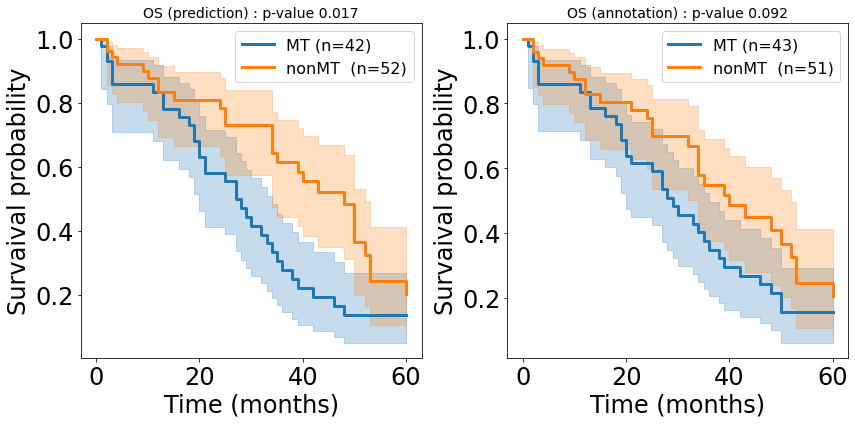

In [4]:
import numpy as np

subset = 'OS'
df = df_analysis.loc[:, ['prediction_MT', 'annotation_MT', '%s'%subset, '%s_E'%subset]].dropna()

kmf = KaplanMeierFitter() 
T_high = df[df['prediction_MT']=='MT']['%s'%subset]
E_high = df[df['prediction_MT']=='MT']['%s_E'%subset]
T_low = df[df['prediction_MT']=='nonMT']['%s'%subset]
E_low = df[df['prediction_MT']=='nonMT']['%s_E'%subset]

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
t = np.linspace(0, 60, 61)
kmf.fit(T_high, event_observed=E_high, timeline=t, label="MT (n=%d)"%(T_high.shape[0]))
ax1 = kmf.plot(ax=ax1, lw=3)
kmf.fit(T_low, event_observed=E_low, timeline=t, label="nonMT  (n=%d)"%(T_low.shape[0]))
ax1 = kmf.plot(ax=ax1, lw=3)
ax1.set_xlabel('Time (months)',color="black", fontsize=24)
ax1.set_ylabel('Survaival probability',color="black", fontsize=24)  
# Log-rank test
prediction_results = logrank_test(T_high, T_low, E_high, E_low, alpha=.99)
ax1.set_title("%s (prediction) : p-value %.3f"%(subset, prediction_results.p_value), fontsize=14)
ax1.legend(facecolor='white', fontsize=16)
ax1.tick_params(axis="x",direction='out', top=False, which='major',color="black", labelsize=24, reset=True)
ax1.tick_params(axis="y",direction='out', right=False, which='major',color="black", labelsize=24, reset=True) 
ax1.grid(False)
ax1.set_facecolor('white')

T_high = df[df['annotation_MT']=='MT']['%s'%subset]
E_high = df[df['annotation_MT']=='MT']['%s_E'%subset]
T_low = df[df['annotation_MT']=='nonMT']['%s'%subset]
E_low = df[df['annotation_MT']=='nonMT']['%s_E'%subset]
ax2 = plt.subplot(122)
t = np.linspace(0, 60, 61)
kmf.fit(T_high, event_observed=E_high, timeline=t, label="MT (n=%d)"%(T_high.shape[0]))
ax2 = kmf.plot(ax=ax2, lw=3)
kmf.fit(T_low, event_observed=E_low, timeline=t, label="nonMT  (n=%d)"%(T_low.shape[0]))
ax2 = kmf.plot(ax=ax2, lw=3)
ax2.set_xlabel('Time (months)',color="black", fontsize=24)
ax2.set_ylabel('Survaival probability',color="black", fontsize=24)    
# Log-rank test
annotation_results = logrank_test(T_high, T_low, E_high, E_low, alpha=.99)
ax2.set_title("%s (annotation) : p-value %.3f"%(subset, annotation_results.p_value), fontsize=14)
ax2.legend(facecolor='white', fontsize=16)
ax2.tick_params(axis="x",direction='out', top=False, which='major',color="black", labelsize=24, reset=True)
ax2.tick_params(axis="y",direction='out', right=False, which='major',color="black", labelsize=24, reset=True)
ax2.grid(False)
ax2.set_facecolor('white')

# Adjust figure settings
plt.tight_layout()
plt.show()

# TCGA cases : Multivariate analysis for prognosis

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_TCGA.csv').loc[:,['case_id', 'Age', 'Stage', 'Tumor_residual_disease', 'HRD score','BRCA1','BRCA2','OS (months)', 'OS Event']]
df_prediction = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_prediction_TCGA.csv').loc[:,['case_id', 'type', 'prediction', 'annotation_MT', 'prediction_MT']]
df_multivariate_analysis = pd.merge(df_prediction, df_annotation, on = 'case_id')
df_multivariate_analysis = df_multivariate_analysis[df_multivariate_analysis['type']!='UD'].rename(columns={'OS (months)':'OS', 'OS Event':'OS_E'})
df_multivariate_analysis = df_multivariate_analysis.dropna(subset=['OS'])

#Convert "MT" to 1, "non_MT" to 0 at column "prediction_MT"
df_multivariate_analysis.loc[df_multivariate_analysis['prediction_MT']=='MT', 'MT Prediction']=1
df_multivariate_analysis.loc[df_multivariate_analysis['prediction_MT']=='nonMT', 'MT Prediction']=0

#Convert "no macroscopic disease" to 0, "1-10 mm" to 1, "11-20 mm" to 2, "">20mm" to 3 at column "Tumor_residual_disease"
df_multivariate_analysis.loc[df_multivariate_analysis['Tumor_residual_disease']=='no macroscopic disease', 'Residual disease after surgery']=0
df_multivariate_analysis.loc[df_multivariate_analysis['Tumor_residual_disease']=='1-10 mm', 'Residual disease after surgery']=1
df_multivariate_analysis.loc[df_multivariate_analysis['Tumor_residual_disease']=='11-20 mm', 'Residual disease after surgery']=2
df_multivariate_analysis.loc[df_multivariate_analysis['Tumor_residual_disease']=='>20 mm', 'Residual disease after surgery']=3

#Convert BRCA abnormality (methylation, germline, somatic or homo del) to 1 at columns "BRCA1" and "BRCA2"
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA1']=='methylation', 'BRCA1 abnormality']=1
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA1']=='germline', 'BRCA1 abnormality']=1
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA1']=='somatic', 'BRCA1 abnormality']=1
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA2']=='methylation', 'BRCA2 abnormality']=1
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA2']=='germline', 'BRCA2 abnormality']=1
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA2']=='somatic', 'BRCA2 abnormality']=1
df_multivariate_analysis.loc[df_multivariate_analysis['BRCA2']=='homo del', 'BRCA2 abnormality']=1

df_multivariate_analysis = df_multivariate_analysis.dropna(subset=['HRD score'])
df_multivariate_analysis = df_multivariate_analysis.dropna(subset=['Residual disease after surgery'])
df_multivariate_analysis = df_multivariate_analysis.drop(columns=['case_id', 'type', 'prediction', 'annotation_MT', 'prediction_MT', 'Tumor_residual_disease', 'BRCA1', 'BRCA2'])
df_multivariate_analysis

,Age,Stage,HRD score,OS,OS_E,MT Prediction,Residual disease after surgery,BRCA1 abnormality,BRCA2 abnormality
0,67,3.0,46.0,70.454022,0.0,0.0,0.0,NaN,NaN
1,60,4.0,50.0,8.416346,1.0,0.0,1.0,NaN,NaN
2,45,4.0,61.0,47.539205,1.0,0.0,3.0,NaN,NaN
3,67,3.0,79.0,49.676168,1.0,0.0,1.0,1.0,NaN
4,65,3.0,57.0,40.536542,0.0,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
91,57,3.0,75.0,1.742447,1.0,1.0,2.0,1.0,NaN
92,66,3.0,47.0,22.323043,0.0,0.0,2.0,NaN,NaN
93,62,1.0,57.0,28.996942,0.0,0.0,0.0,NaN,NaN
98,48,3.0,56.0,39.681757,0.0,0.0,1.0,NaN,NaN


In [52]:
# Multivariate Survival Analysis: Cox regression

from lifelines import CoxPHFitter

# When BRCA status is Nan fill '0' 
df_multivariate_analysis = df_multivariate_analysis.fillna(0)

cph = CoxPHFitter()
cph.fit(df_multivariate_analysis, duration_col='OS', event_col='OS_E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 77 total observations, 23 right-censored observations>
             duration col = 'OS'
                event col = 'OS_E'
      baseline estimation = breslow
   number of observations = 77
number of events observed = 54
   partial log-likelihood = -171.31
         time fit was run = 2023-03-19 00:41:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
Age                              0.04       1.04       0.02             0.00             0.07                 1.00                 1.07
Stage                            0.99       2.70       0.36             0.30             1.69                 1.34                 5.41
HRD score                       -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
MT Prediction                    0.62       1.86       0.30             0.04             1.20                 1.04                 3.33
Residual disease after surgery   0.31       1.37       0.16            -0.00             0.63                 1.00                 1.87
BRCA1 abnormality               -0.48       0.62       0.44            -1.33             0.38                 0.26                 1.46
BRCA2 abnormality                0.52       1.68       0.58            -0.62             1.65                 0.54                 5.22

                                   z    p   -log2(p)
covariate                                           
Age                             2.25 0.02       5.36
Stage                           2.79 0.01       7.57
HRD score                      -0.06 0.95       0.08
MT Prediction                   2.10 0.04       4.81
Residual disease after surgery  1.95 0.05       4.28
BRCA1 abnormality              -1.09 0.27       1.87
BRCA2 abnormality               0.90 0.37       1.43
---
Concordance = 0.71
Partial AIC = 356.63
log-likelihood ratio test = 28.89 on 7 df
-log2(p) of ll-ratio test = 12.69

<AxesSubplot:xlabel='log(HR) (95% CI)'>

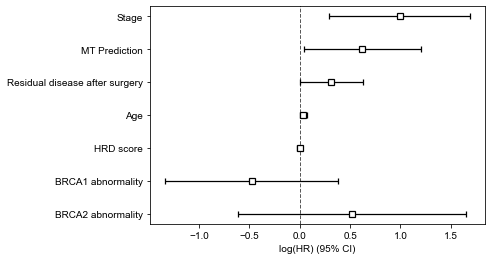

In [53]:
cph.plot(columns=['Stage', 'MT Prediction', 'Residual disease after surgery', 'Age', 'HRD score', 'BRCA1 abnormality', 'BRCA2 abnormality'], hazard_ratios=False)

# TCGA cases : associtation between predictions and mesenchymal scores

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_TCGA.csv').loc[:,['case_id','HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', ]]
df_prediction = pd.read_csv('/Users/aueda/Python/Kindai/5class/predictions_TCGA/HE_prediction_TCGA.csv').loc[:,['case_id', 'type', 'annotation_MT', 'prediction_MT']]
df_analysis = pd.merge(df_prediction, df_annotation, on = 'case_id')
df_analysis = df_analysis[df_analysis['type']!='UD'].dropna()
df_analysis.head(3)

,case_id,type,annotation_MT,prediction_MT,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
2,TCGA-23-1021,PG,nonMT,nonMT,0.279932
3,TCGA-23-1022,PG,nonMT,nonMT,0.205789
4,TCGA-23-1023,PG,nonMT,nonMT,0.569455


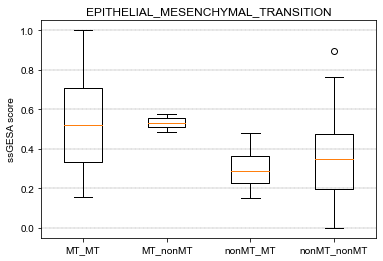

MannWhitneyU test
MT_MT vs MT_nonMT : 0.8769
MT_MT vs nonMT_MT : 0.0385
MT_MT vs nonMT_nonMT : 0.0004
MT_nonMT vs nonMT_MT : 0.1333
MT_nonMT vs nonMT_nonMT : 0.1487
nonMT_MT vs nonMT_nonMT : 0.6224


,Prediction,Annotation,Cases,Median,25%ile,75%ile,Mean,SD
MT_MT,MT,MT,38,0.518954,0.335884,0.710016,0.537395,0.223579
MT_nonMT,MT,nonMT,2,0.531893,0.509061,0.554725,0.531893,0.045665
nonMT_MT,nonMT,MT,4,0.286914,0.225421,0.361950,0.300456,0.119589
nonMT_nonMT,nonMT,nonMT,40,0.347249,0.197302,0.473808,0.343542,0.201764


In [35]:
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['font.family'] = 'Arial'

# Prediction - Annotation
MT_MT = df_analysis[(df_analysis['prediction_MT']=='MT')&(df_analysis['annotation_MT']=='MT')]['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'].values.tolist()
MT_nonMT = df_analysis[(df_analysis['prediction_MT']=='MT')&(df_analysis['annotation_MT']=='nonMT')]['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'].values.tolist()
nonMT_MT = df_analysis[(df_analysis['prediction_MT']=='nonMT')&(df_analysis['annotation_MT']=='MT')]['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'].values.tolist()
nonMT_nonMT = df_analysis[(df_analysis['prediction_MT']=='nonMT')&(df_analysis['annotation_MT']=='nonMT')]['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'].values.tolist()

# 点数のタプル
points = (MT_MT, MT_nonMT, nonMT_MT, nonMT_nonMT)

# 箱ひげ図
fig, ax = plt.subplots()
bp = ax.boxplot(points) 
ax.set_xticklabels(['MT_MT', 'MT_nonMT', 'nonMT_MT', 'nonMT_nonMT'])
ax.set_ylabel('ssGESA score')
ax.set_facecolor('white')
ax.tick_params(axis="x",direction='out', top=False, which='major',color="black", reset=True)
ax.tick_params(axis="y",direction='out', right=False, which='major',color="black", reset=True) 
ax.grid(axis='y', which='major',color='black', linestyle='--', linewidth=0.25)
plt.title('EPITHELIAL_MESENCHYMAL_TRANSITION')
plt.show()

df_summary = pd.DataFrame({
                                                     'Prediction': ["MT", "MT", "nonMT", "nonMT"],
                                                     'Annotation': ["MT", "nonMT", "MT", "nonMT"],
                                                     'Cases' :[len(MT_MT), len(MT_nonMT), len(nonMT_MT), len(nonMT_nonMT)],
                                                     'Median': [np.median(MT_MT), np.median(MT_nonMT), np.median(nonMT_MT), np.median(nonMT_nonMT)],
                                                     '25%ile': [np.quantile(MT_MT, 0.25),np.quantile(MT_nonMT, 0.25),np.quantile(nonMT_MT, 0.25),np.quantile(nonMT_nonMT, 0.25)],
                                                     '75%ile': [np.quantile(MT_MT, 0.75),np.quantile(MT_nonMT, 0.75),np.quantile(nonMT_MT, 0.75),np.quantile(nonMT_nonMT, 0.75)],
                                                     'Mean': [np.mean(MT_MT), np.mean(MT_nonMT), np.mean(nonMT_MT), np.mean(nonMT_nonMT)],
                                                      'SD' : [np.std(MT_MT), np.std(MT_nonMT), np.std(nonMT_MT), np.std(nonMT_nonMT)]})

print('MannWhitneyU test')
print('MT_MT vs MT_nonMT : %.4f'%stats.mannwhitneyu(MT_MT, MT_nonMT, alternative='two-sided').pvalue)
print('MT_MT vs nonMT_MT : %.4f'%stats.mannwhitneyu(MT_MT, nonMT_MT, alternative='two-sided').pvalue)
print('MT_MT vs nonMT_nonMT : %.4f'%stats.mannwhitneyu(MT_MT, nonMT_nonMT, alternative='two-sided').pvalue)
print('MT_nonMT vs nonMT_MT : %.4f'%stats.mannwhitneyu(MT_nonMT, nonMT_MT, alternative='two-sided').pvalue)
print('MT_nonMT vs nonMT_nonMT : %.4f'%stats.mannwhitneyu(MT_nonMT, nonMT_nonMT, alternative='two-sided').pvalue)
print('nonMT_MT vs nonMT_nonMT : %.4f'%stats.mannwhitneyu(nonMT_MT, nonMT_nonMT, alternative='two-sided').pvalue)

df_summary.index = ['MT_MT', 'MT_nonMT', 'nonMT_MT', 'nonMT_nonMT']
df_summary

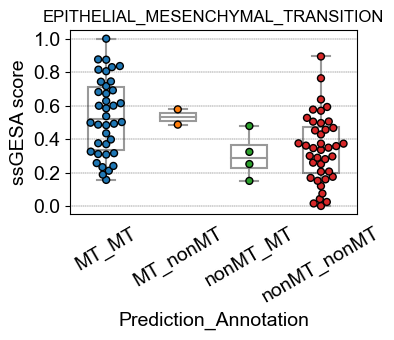

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'

df_analysis.loc[(df_analysis['prediction_MT']=='MT')&(df_analysis['annotation_MT']=='MT'), 'Prediction_Annotation'] = 'MT_MT'
df_analysis.loc[(df_analysis['prediction_MT']=='MT')&(df_analysis['annotation_MT']=='nonMT'), 'Prediction_Annotation'] = 'MT_nonMT'
df_analysis.loc[(df_analysis['prediction_MT']=='nonMT')&(df_analysis['annotation_MT']=='MT'), 'Prediction_Annotation'] = 'nonMT_MT'
df_analysis.loc[(df_analysis['prediction_MT']=='nonMT')&(df_analysis['annotation_MT']=='nonMT'), 'Prediction_Annotation'] = 'nonMT_nonMT'
df_analysis = df_analysis.rename(columns={'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION':'ssGESA score'})

fig, ax1 = plt.subplots(figsize=(4,3.5), dpi=100) #Figureのサイズと解像度
sns.swarmplot(ax=ax1, x='Prediction_Annotation', y='ssGESA score', data=df_analysis, size=5, edgecolor='black', linewidth=1, order=['MT_MT', 'MT_nonMT', 'nonMT_MT', 'nonMT_nonMT'])
sns.boxplot(ax=ax1, x='Prediction_Annotation', y='ssGESA score', data=df_analysis, color='white', whis=np.inf, width=0.5, order=['MT_MT', 'MT_nonMT', 'nonMT_MT', 'nonMT_nonMT'])
ax1.tick_params(top=False, right=False, left=True, bottom=False)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='x', labelrotation=30)
ax1.set_title('EPITHELIAL_MESENCHYMAL_TRANSITION')
ax1.set_facecolor('white')
ax1.grid(axis='y', which='major',color='black', linestyle='--', linewidth=0.25)
ax1.set_xlabel('Prediction_Annotation', fontsize=14)
ax1.set_ylabel('ssGESA score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Fleiss' Kappa analysis in JGOG3022A1 cases

In [73]:
def compute_fleiss_kappa(rate_list: list, n: int) -> float:
    N = len(rate_list)
    k = len(rate_list[0])
    # 入力された情報の確認
    print('Number of observers = {}'.format(n))
    print('Number of cases = {}'.format(N))
    print('Number of categoris to evaluate = {}'.format(k))

    P_bar = sum([(sum([el**2 for el in row]) - n) / (n * (n - 1)) for row in rate_list]) / N
    print('P_bar  = {}'.format(P_bar))

    Pe_bar = sum([(sum([row[j] for row in rate_list]) / (N * n)) ** 2 for j in range(k)])
    print('Pe_bar  = {}'.format(Pe_bar))

    kappa = float(0)
    try:
        kappa = (P_bar - Pe_bar) / (1 - Pe_bar)
    except ZeroDivisionError:
        kappa = float(1)
        
    return kappa

### Four subtype classification

#### Fleiss' Kappa anlaysis

In [112]:
df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_JGOG.csv').iloc[:,2:6]
df_annotation = df_annotation.fillna('NA')
evaluation_list = list()
for i, row in df_annotation.iterrows():
    evaluation = row.values.tolist()
    evaluation_list.append([evaluation.count('MT'), evaluation.count('IR'), evaluation.count('PG'), evaluation.count('SP'), evaluation.count('NA')])
print('kappa = {}'.format(compute_fleiss_kappa(evaluation_list, n=4)))    

Number of observers = 4
Number of cases = 80
Number of categoris to evaluate = 5
P_bar  = 0.6562499999999999
Pe_bar  = 0.31791015624999996
kappa = 0.4960341322337713


#### Cohen’s Kappa Score

In [123]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import itertools

# load label
df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_JGOG.csv').iloc[:,2:6]
df_annotation = df_annotation.fillna('NA')
observers = df_annotation.columns.tolist()
for pair in itertools.combinations(observers, 2):
    _observer1 = df_annotation.loc[:,pair[0]].values.tolist()
    _observer2 = df_annotation.loc[:,pair[1]].values.tolist()
    match = sum(np.array(_observer1)==np.array(_observer2)) / len(_observer1) * 100
    k = cohen_kappa_score(_observer1,_observer2)
    print("Observer %s vs %s : Match %.1f %%, Cohen kappa score: %.3f"%(pair[0], pair[1], match, k))

Observer C. M. vs H. N. : Match 60.0 %, Cohen kappa score: 0.412
Observer C. M. vs T. O. : Match 67.5 %, Cohen kappa score: 0.514
Observer C. M. vs M. Y. : Match 63.7 %, Cohen kappa score: 0.479
Observer H. N. vs T. O. : Match 63.7 %, Cohen kappa score: 0.458
Observer H. N. vs M. Y. : Match 61.3 %, Cohen kappa score: 0.449
Observer T. O. vs M. Y. : Match 77.5 %, Cohen kappa score: 0.673


### Two class (MT vs non-MT) classification

#### Fleiss' Kappa anlaysis

In [113]:
df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_JGOG.csv').iloc[:,2:6]
df_annotation = df_annotation.fillna('NA')
df_annotation = df_annotation.replace({'IR':'nonMT', 'PG':'nonMT', 'SP':'nonMT'})
evaluation_list = list()
for i, row in df_annotation.iterrows():
    evaluation = row.values.tolist()
    evaluation_list.append([evaluation.count('MT'), evaluation.count('nonMT'), evaluation.count('NA')])
print('kappa = {}'.format(compute_fleiss_kappa(evaluation_list, n=4)))    

Number of observers = 4
Number of cases = 80
Number of categoris to evaluate = 3
P_bar  = 0.7583333333333334
Pe_bar  = 0.51677734375
kappa = 0.4998854802419737


#### Cohen’s Kappa Score 

In [124]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import itertools

# load label
df_annotation = pd.read_csv('/Users/aueda/Python/Kindai/HE_annotation_JGOG.csv').iloc[:,2:6]
df_annotation = df_annotation.fillna('NA')
df_annotation = df_annotation.replace({'IR':'nonMT', 'PG':'nonMT', 'SP':'nonMT'})
observers = df_annotation.columns.tolist()
for pair in itertools.combinations(observers, 2):
    _observer1 = df_annotation.loc[:,pair[0]].values.tolist()
    _observer2 = df_annotation.loc[:,pair[1]].values.tolist()
    match = sum(np.array(_observer1)==np.array(_observer2)) / len(_observer1) * 100
    k = cohen_kappa_score(_observer1,_observer2)
    print("Observer %s vs %s : Match %.1f %%, Cohen kappa score: %.3f"%(pair[0], pair[1], match, k))

Observer C. M. vs H. N. : Match 75.0 %, Cohen kappa score: 0.501
Observer C. M. vs T. O. : Match 77.5 %, Cohen kappa score: 0.526
Observer C. M. vs M. Y. : Match 75.0 %, Cohen kappa score: 0.463
Observer H. N. vs T. O. : Match 70.0 %, Cohen kappa score: 0.401
Observer H. N. vs M. Y. : Match 72.5 %, Cohen kappa score: 0.450
Observer T. O. vs M. Y. : Match 85.0 %, Cohen kappa score: 0.678
